# **Travelling Salesman Problem**

### **Initial Setup**

In [1]:
import pandas as pd
import numpy as np
import random
from sys import maxsize 
import matplotlib.cm as cm
import itertools
from collections import defaultdict
import matplotlib.pyplot as plt
from itertools import permutations
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.spatial import distance_matrix
import plotly.graph_objects as go

In [2]:
pwd

'c:\\Users\\Maisam\\Downloads\\Travelling Salesman Problem'

In [3]:
tiny = pd.read_csv('C:/Users/Maisam/Downloads/Travelling Salesman Problem/1. Dataset/tiny.csv', names=['A', 'B'], header=None)
small = pd.read_csv('C:/Users/Maisam/Downloads/Travelling Salesman Problem/1. Dataset/small.csv', names=['A', 'B'], header=None)
medium = pd.read_csv('C:/Users/Maisam/Downloads/Travelling Salesman Problem/1. Dataset/medium.csv', names=['A', 'B'], header=None)
large = pd.read_csv('C:/Users/Maisam/Downloads/Travelling Salesman Problem/1. Dataset/large.csv', names=['A', 'B'], header=None)

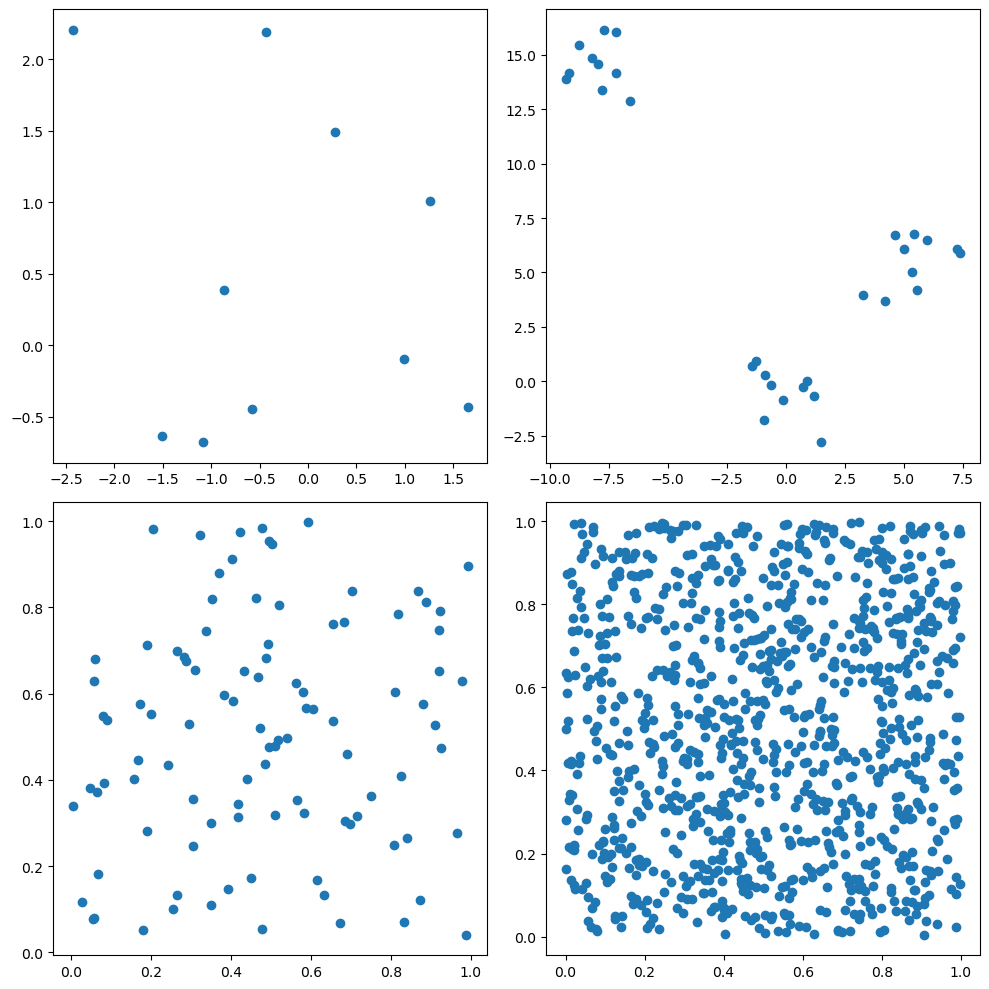

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].scatter(tiny['A'], tiny['B'])
axs[0, 1].scatter(small['A'], small['B'])
axs[1, 0].scatter(medium['A'], medium['B'])
axs[1, 1].scatter(large['A'], large['B'])
plt.tight_layout()
plt.show()

### **Working on Tiny City Dataset:**

#### Brute Force:

Try every possible route, calculate the total distance for each, and pick the shortest one.

It's guaranteed to give the optimal solution — but it becomes very slow as the number of cities increases due to factorial time complexity (n!).

In [5]:
def euclidean_distance(p1, p2):
    return ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)**0.5

In [6]:
coordinates = tiny[['A', 'B']].values.tolist()
# We now have a list like: [[x1, y1], [x2, y2], ..., [xn, yn]]

distances = [[euclidean_distance(p1, p2) for p2 in coordinates] for p1 in coordinates]
# We now have a square matrix of pairwise distances.

n = len(coordinates)
all_permutations = itertools.permutations(range(n))
# Generates a list of all possible paths. Each permutation is a tuple like (0, 1, 2, ..., n-1).

best_path = None
min_distance = float('inf')
# Initialize variables to store the best path and its distance.

In [7]:
%%time
for path in all_permutations:
    total_distance = sum(distances[path[i]][path[i+1]] for i in range(n-1))
    total_distance += distances[path[n-1]][path[0]]
    # Sums the distances between consecutive cities in the route.
    # Adds the distance from the last city back to the first (to make the path circular).

    if total_distance < min_distance:
        min_distance = total_distance
        best_path = path

print("Best Path:", best_path)
print("Minimum Distance:", min_distance)

Best Path: (0, 3, 9, 6, 7, 2, 8, 5, 1, 4)
Minimum Distance: 12.516978039789697
CPU times: total: 7.2 s
Wall time: 7.36 s


It took us around 18 seconds to find the best path. With just 10 datapoints this is extremely slow. Nevertheless let´s show the shortest path between the data points.

In [8]:
def print_best_route(best_path):
    plt.figure(figsize=(5,5))
    
    for i, index in enumerate(best_path):
        x, y = coordinates[index]
        plt.text(x, y, str(i+1), fontsize=12, color='black', ha='right', va='top')
    
    plt.plot([coordinates[i][0] for i in best_path], [coordinates[i][1] for i in best_path], 'ro-')
    plt.plot([coordinates[best_path[-1]][0], coordinates[best_path[0]][0]], [coordinates[best_path[-1]][1], coordinates[best_path[0]][1]], 'ro-')
    plt.title('Best Path for the Salesman')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.show()

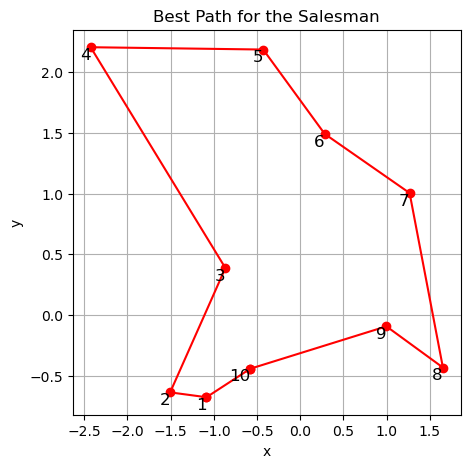

In [9]:
print_best_route(best_path)

#### DP - Held-Karp Algorithm:

Instead of checking all full routes from scratch like brute-force does, Held-Karp builds up solutions step-by-step. It stores results of smaller problems and reuses them.

In [10]:
def tsp_dp(coordinates):
    n = len(coordinates)
    distances = [[euclidean_distance(p1, p2) for p2 in coordinates] for p1 in coordinates]
    
    # Returns a Distance Matrix like:
    #[[0.0, 1.0, 1.0],
    #[1.0, 0.0, 1.41],
    #[1.0, 1.41, 0.0]]
    
    dp = [[float('inf')] * n for _ in range(1 << n)]
    dp[1][0] = 0 
    
    # Setting up a DP Table:
    # dp[mask][i] = the minimum distance to reach city i having visited the set of cities represented by mask.
    # So dp[1][0] = 0 says: "Starting at city 0, the cost is 0."

    # Return DP Masked Table like:
    # [[inf, inf, inf],  # mask = 0 (000): visited nothing
    # [0, inf, inf],    # mask = 1 (001): only city 0 is visited, starting point
    #   ...
    # [inf, inf, inf]]  # up to mask = 7 (111): all cities visited
        
    for mask in range(1 << n):
        for u in range(n):
            if (mask & (1 << u)) == 0: 
                continue
            for v in range(n):
                if (mask & (1 << v)) == 0:
                    continue
                dp[mask][u] = min(dp[mask][u], dp[mask ^ (1 << u)][v] + distances[v][u])

    min_distance = float('inf')
    for u in range(1, n):
        min_distance = min(min_distance, dp[(1 << n) - 1][u] + distances[u][0])
    
    mask = (1 << n) - 1
    last = 0
    best_path = [0]
    for _ in range(n - 1):
        next_city = min(range(n), key=lambda v: dp[mask][v] + distances[v][last] if mask & (1 << v) else float('inf'))
        best_path.append(next_city)
        mask ^= (1 << next_city)
        last = next_city
    best_path.append(0)
    return best_path, min_distance

In [11]:
%%time
best_path, min_distance = tsp_dp(coordinates)

print("Best Path:", best_path)
print("Minimum distance:", min_distance)

Best Path: [0, 3, 9, 6, 7, 2, 8, 5, 1, 4, 0]
Minimum distance: 12.516978039789697
CPU times: total: 31.2 ms
Wall time: 20.7 ms


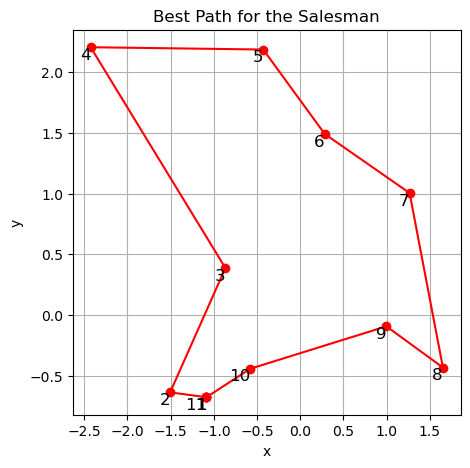

In [12]:
print_best_route(best_path)

#### Branch and Bound Method:

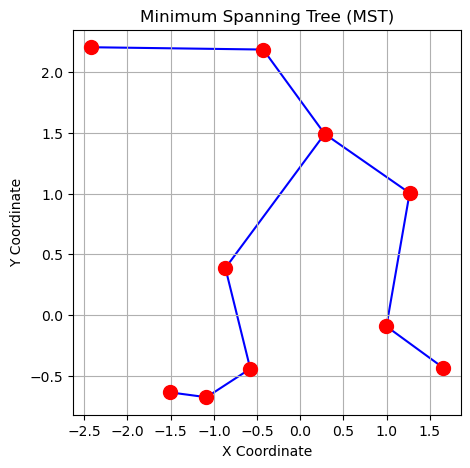

In [13]:
# MST is a tree that connects all the cities with the least possible total distance, but without any cycles.
# It’s used as a lower bound estimate — a good guess for how short a TSP route could be.

coordinates = np.array(coordinates)
dist_matrix = distance_matrix(coordinates, coordinates)
mst = minimum_spanning_tree(dist_matrix).toarray()

plt.figure(figsize=(5, 5))
plt.scatter(coordinates[:, 0], coordinates[:, 1], color='red', s=100, zorder=5)

for i in range(len(coordinates)):
    for j in range(len(coordinates)):
        if mst[i, j] != 0: 
            plt.plot([coordinates[i, 0], coordinates[j, 0]], 
                     [coordinates[i, 1], coordinates[j, 1]], 
                     'b-', zorder=1)

plt.title("Minimum Spanning Tree (MST)")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid(True)
plt.show()

**MST Using Kruskal's Algorithm:**

In [14]:
# Helper function to find the root of a vertex
def find(parent, i):
    if parent[i] == i:
        return i
    return find(parent, parent[i])

In [15]:
# Helper function to union two subsets
def union(parent, rank, x, y):
    root_x = find(parent, x)
    root_y = find(parent, y)
    
    if rank[root_x] < rank[root_y]:
        parent[root_x] = root_y
    elif rank[root_x] > rank[root_y]:
        parent[root_y] = root_x
    else:
        parent[root_y] = root_x
        rank[root_x] += 1

In [16]:
def kruskal_mst(coordinates):
    n = len(coordinates)
    edges = []

    # Step 1: Create a list of all edges with their distances
    for i in range(n):
        for j in range(i + 1, n):
            distance = np.linalg.norm(np.array(coordinates[i]) - np.array(coordinates[j]))
            edges.append((distance, i, j))

    # Step 2: Sort all edges by weight (distance)
    edges = sorted(edges, key=lambda x: x[0])

    parent = list(range(n))
    rank = [0] * n

    mst_edges = []

    # Step 3: Process each edge, checking if it forms a cycle
    for distance, u, v in edges:
        root_u = find(parent, u)
        root_v = find(parent, v)

        # If including this edge does not form a cycle
        if root_u != root_v:
            mst_edges.append((u, v))
            union(parent, rank, root_u, root_v)

        # Stop if we have found enough edges for the MST
        if len(mst_edges) == n - 1:
            break

    return mst_edges

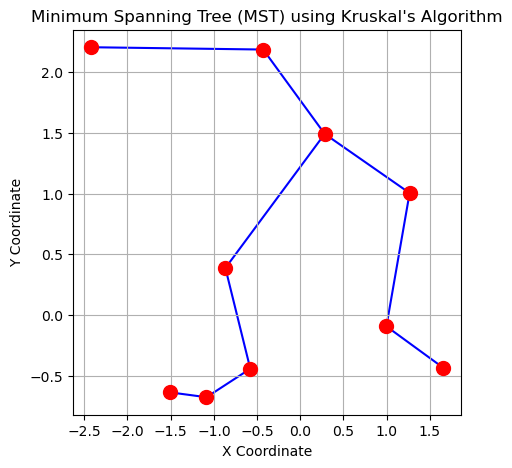

In [17]:
mst_edges = kruskal_mst(coordinates)
plt.figure(figsize=(5, 5))
plt.scatter(coordinates[:, 0], coordinates[:, 1], color='red', s=100, zorder=5)

for u, v in mst_edges:
    plt.plot([coordinates[u, 0], coordinates[v, 0]], 
             [coordinates[u, 1], coordinates[v, 1]], 
             'b-', zorder=1)

plt.title("Minimum Spanning Tree (MST) using Kruskal's Algorithm")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid(True)
plt.show()

In [18]:
def tsp_branch_and_bound(coordinates):
    n = len(coordinates)
    
    distance_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            distance_matrix[i][j] = euclidean_distance(coordinates[i], coordinates[j])
            distance_matrix[j][i] = distance_matrix[i][j]

    min_distance = float('inf')
    best_path = []
    initial_path = [0]
    initial_bound = 0
    
    def branch_and_bound(path, bound, level):
        nonlocal min_distance, best_path
        
        if level == n - 1:
            current_distance = bound + distance_matrix[path[-1]][path[0]]
            if current_distance < min_distance:
                min_distance = current_distance
                best_path = path + [path[0]]
            return
        
        for i in range(1, n):
            if i not in path:
                new_bound = bound + distance_matrix[path[-1]][i]
                if new_bound < min_distance:
                    branch_and_bound(path + [i], new_bound, level + 1)

    branch_and_bound(initial_path, initial_bound, 0)

    return best_path, min_distance

In [19]:
%%time
coordinates = tiny[['A', 'B']].values.tolist()
best_path, min_distance = tsp_branch_and_bound(coordinates)
print("Best Path:", best_path)
print("Minimum distance:", min_distance)

Best Path: [0, 3, 9, 6, 7, 2, 8, 5, 1, 4, 0]
Minimum distance: 12.516978039789697
CPU times: total: 172 ms
Wall time: 169 ms


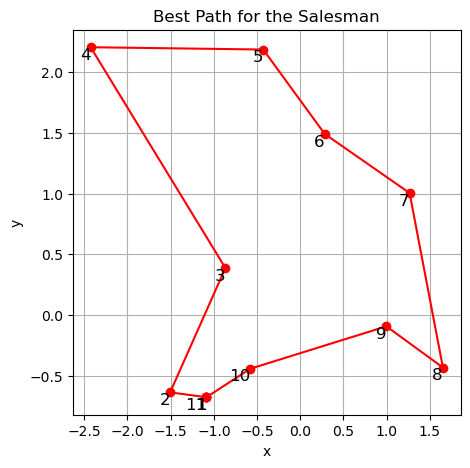

In [20]:
print_best_route(best_path)

### **Working on Small City Dataset:**

##### Nearest Neighbours:

In [21]:
def nearest_neighbor(coordinates):
    n = len(coordinates)
    unvisited = list(range(n))
    path = []
    
    current_city = unvisited.pop(0)
    path.append(current_city)
    
    while unvisited:
        nearest_city = min(unvisited, key=lambda city: euclidean_distance(coordinates[current_city], coordinates[city]))
        path.append(nearest_city)
        unvisited.remove(nearest_city)
        current_city = nearest_city
    
    path.append(path[0])
    total_distance = sum(euclidean_distance(coordinates[path[i]], coordinates[path[i + 1]]) for i in range(n))
    return path, total_distance

In [22]:
%%time
coordinates = small[['A', 'B']].values.tolist()
best_path, min_distance = nearest_neighbor(coordinates)
print("Best path:", best_path)
print("Minimum distance:", min_distance)

Best path: [0, 19, 6, 9, 29, 22, 20, 28, 4, 13, 3, 7, 25, 15, 12, 24, 8, 17, 16, 21, 27, 10, 11, 14, 2, 23, 5, 18, 26, 1, 0]
Minimum distance: 66.79316375709949
CPU times: total: 15.6 ms
Wall time: 16.2 ms


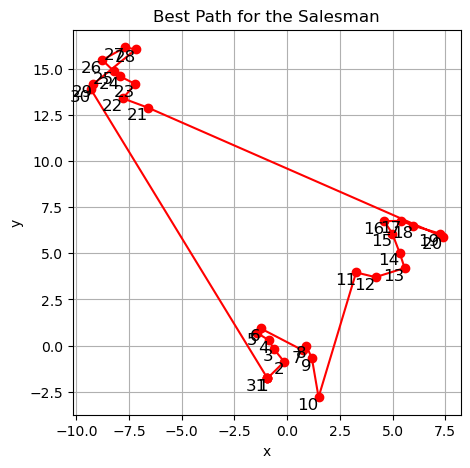

In [23]:
print_best_route(best_path)

#### Genetic Algorithm:

In [24]:
def create_route(n):
    route = list(range(n))
    random.shuffle(route)
    return route

In [25]:
def initial_population(pop_size, n):
    return [create_route(n) for _ in range(pop_size)]

In [ ]:
chromosome = initial_population(1, len(coordinates))
print(chromosome)

# The whole genetic algorithm builds on this:
# These randomly generated routes are your starting point
# Over time, you’ll evaluate them (fitness), select the best, cross them over, and mutate them

[[1, 16, 0, 13, 27, 26, 5, 14, 4, 23, 25, 19, 22, 29, 10, 8, 11, 9, 17, 6, 20, 3, 2, 28, 18, 21, 24, 15, 7, 12]]


In [27]:
def route_distance(route, coordinates):
    return (
        sum(
            euclidean_distance(coordinates[route[i]], coordinates[route[i + 1]])
            for i in range(len(route) - 1)
        ) 
        + euclidean_distance(coordinates[route[-1]], coordinates[route[0]])
    )

In [28]:
def fitness(route, coordinates):
    return 1 / route_distance(route, coordinates)

In [29]:
chromosome_fitness = fitness(chromosome[0], coordinates)
print("Fitness of the chromosome:", chromosome_fitness)

Fitness of the chromosome: 0.003330561409674305


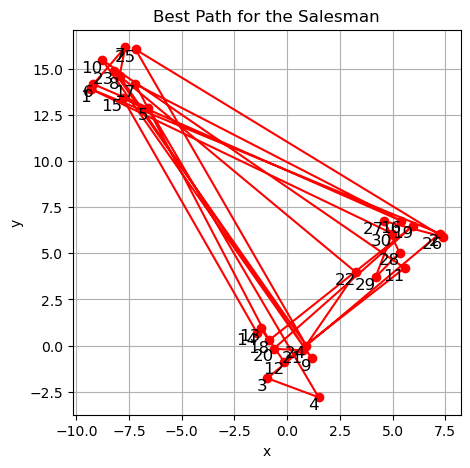

In [30]:
print_best_route(chromosome[0])

In [34]:
population = initial_population(pop_size=100, n=len(coordinates))
elite_size = 20


population = sorted(population, key=lambda x: fitness(x, coordinates), reverse=True)
parents = population[:elite_size]

In [35]:
def crossover(parent1, parent2):
    start, end = sorted([random.randint(0, len(parent1) - 1) for _ in range(2)])
    child = [None] * len(parent1)
    child[start:end] = parent1[start:end]
    p2 = [item for item in parent2 if item not in child]
    child = [p2.pop(0) if item is None else item for item in child]
    return child

In [36]:
def mutate(route, mutation_rate):
    for i in range(len(route)):
        if random.random() < mutation_rate:
            j = random.randint(0, len(route) - 1)
            route[i], route[j] = route[j], route[i]
    return route

In [37]:
def plot_route(route, coordinates, generation, line):
    x = [coordinates[city][0] for city in route] + [coordinates[route[0]][0]]
    y = [coordinates[city][1] for city in route] + [coordinates[route[0]][1]]
    line.set_data(x, y)
    plt.title(f"Generation {generation + 1}")

In [38]:
def genetic_algorithm(coordinates, pop_size=100, elite_size=20, mutation_rate=0.01, generations=300):
    n = len(coordinates)
    population = initial_population(pop_size, n)
    history = []
    for gen in range(generations):
        # Rank routes based on fitness
        population = sorted(population, key=lambda x: fitness(x, coordinates), reverse=True)
        # Select the best routes to be parents
        parents = population[:elite_size]
        # Generate children
        children = []
        for _ in range(pop_size - elite_size):
            parent1, parent2 = random.sample(parents, 2)
            child = crossover(parent1, parent2)
            children.append(mutate(child, mutation_rate))
        # Form the new population
        population = parents + children
        # Best route and distance of the current generation
        best_route = population[0]
        best_distance = route_distance(best_route, coordinates)
        history.append((best_route, gen, best_distance))
    best_route = population[0]
    best_distance = route_distance(best_route, coordinates)
    return history, best_route, best_distance

In [39]:
def plot_route_animation(history, coordinates):
    frames = []
    for gen, (route, _, _) in enumerate(history):
        x = [coordinates[city][0] for city in route] + [coordinates[route[0]][0]]
        y = [coordinates[city][1] for city in route] + [coordinates[route[0]][1]]
        frames.append(go.Frame(
            data=[go.Scatter(x=x, y=y, mode='lines+markers', marker=dict(size=8), line=dict(color='blue'))],
            name=f'Generation {gen + 1}',
            layout=go.Layout(title_text=f"Generation {gen + 1} - Traveling Salesman Problem")
        ))
    
    fig = go.Figure(
        data=[frames[0].data[0]],
        layout=go.Layout(
            title="Traveling Salesman Problem - Best Route Per Generation",
            xaxis=dict(title="X Coordinate"),
            yaxis=dict(title="Y Coordinate"),
            updatemenus=[dict(type="buttons",
                              buttons=[dict(label="Play",
                                            method="animate",
                                            args=[None, dict(frame=dict(duration=50, redraw=True),
                                                             fromcurrent=True,
                                                             mode='immediate')]),
                                       dict(label="Pause",
                                            method="animate",
                                            args=[[None], dict(frame=dict(duration=0, redraw=False),
                                                               mode='immediate')])])]
        ),
        frames=frames
    )
    fig.show()

In [40]:
%%time
coordinates = small[['A', 'B']].values.tolist()
history, best_route, best_distance = genetic_algorithm(coordinates)
print("Best route:", best_route)
print("Best distance:", best_distance)

Best route: [12, 7, 3, 27, 11, 14, 2, 18, 5, 23, 26, 1, 10, 22, 29, 9, 6, 19, 0, 13, 4, 20, 28, 25, 15, 21, 16, 17, 8, 24]
Best distance: 62.524314344266024
CPU times: total: 1.11 s
Wall time: 1.13 s


In [41]:
plot_route_animation(history, coordinates)